# Flujos Caóticos y Redes Neuronales

In [ ]:
#!pip install tensorflow
#!pip install keras
#!pip install pydot
#!pip install graphviz

In [ ]:
import numpy as np

## 1) Flujo Caótico

### Generacion del Dataset
Como primer paso, vamos a generar la serie temporal a partir de un sistema dinámico que ya vimos en la Practica 2.
Sistema de Rossler:
$$
\dot{x} = -y-z\\
\dot{y} = x+ay\\
\dot{z} = b+z(x-c)
$$
Usaremos los códigos que ya usamos durtante la materia para hacerlo integrando las ecuaciones por el método de Euler.

In [ ]:
def ecuaciones(x,y,z, a=0.1, b=0.1, c=14):
    '''
    Recibe:
       x, y: Variables del sistema
       param: Lista con los parámetros del sistema
    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''
    x_dot = 1*(-y - z)
    y_dot = 1*(x + a*y)
    z_dot = 1*(b + z*(x - c))

    return x_dot, y_dot, z_dot


def integrar_ecuaciones(total_time,dt,X0):

    '''
    Recibe:
       total_time: Tiempo total del integración
       dt: Paso temporal (h del método)
       X0: Lista con [x0,y0] valores iniciales de la integración
       params: Lista con los parámetros del sistema
    Devuelve:
       x_s, y_s: Vectores con las soluciones para ambas variables
       num_steps: Numero de pasos de integracion
    '''

    num_steps = int(np.divide(total_time,dt))

    # Empty vectors
    xs = np.empty(num_steps)
    ys = np.empty(num_steps)
    zs = np.empty(num_steps)

    # Set initial values
    xs[0], ys[0], zs[0] = X0

    # Empty vectors
    x_dot = np.empty(num_steps)
    y_dot = np.empty(num_steps)
    z_dot = np.empty(num_steps)

    # Set initial derivatives values
    x_dot[0], y_dot[0], z_dot[0] = ecuaciones(xs[0], ys[0], zs[0])

    # Integramos con método de Euler
    for i in range(num_steps-1):
        x_dot[i], y_dot[i], z_dot[i] = ecuaciones(xs[i], ys[i], zs[i])
        xs[i + 1] = xs[i] + (x_dot[i] * dt)
        ys[i + 1] = ys[i] + (y_dot[i] * dt)
        zs[i + 1] = zs[i] + (z_dot[i] * dt)

    return xs, ys, zs, num_steps

In [ ]:
# Simulamos los datos
total_time = 5000
dt = 0.005
X0 = (10, 10, 0)

xs, ys, zs, num_steps = integrar_ecuaciones(total_time,dt,X0)

Primero vamos a normalizar y subsamplear la a serie temporal.

In [ ]:
# Proporcion entre train y test
proporcion = 0.75

# Indice de separacion entre train y test
indice_test = int(proporcion * num_steps)

# Subsampleo temporal de la señal
subsampleo = 100

#Maximo de la señal para normalizar
maximo = np.max(np.abs(xs))

# Separamos la serie en 2 partes, una para el train set y otra para el test set.
training_set_scaled = np.divide(xs[:indice_test:subsampleo],maximo)
test_set_scaled = np.divide(xs[indice_test::subsampleo],maximo)

Ahora, armaremos el dataset a utilizar a partir de esta serie temporal. Entrenaremos la red de manera de que la entrada sean N pasos consecutivos de la serie y su objetivo sea predecir el siguiente paso.

La cantidad de pasos para atras que verá la red esta determinada por la variable `look_back`.

In [ ]:
look_back = 20

X_train = []
Y_train = []

# Recorremos la serie correspondiente al train y armamos el dataset
for i in range(look_back, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-look_back:i])
    Y_train.append(training_set_scaled[i])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_test = []
Y_test = []

# Recorremos la serie correspondiente al test y armamos el dataset
for i in range(look_back, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-look_back:i])
    Y_test.append(test_set_scaled[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)

Noten las dimensiones de las matrices obtenidas.

In [ ]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Train y shape", Y_train.shape)

print("Test matrix shape", X_test.shape)
print("Test y shape", Y_test.shape)

Train matrix shape (7480, 20)
Train y shape (7480,)
Test matrix shape (2480, 20)
Test y shape (2480,)


## 2) Redes Neuronales - Regresión

### Modelado

Vamos a definir una red neuronal de la misma forma que lo hicimos anteriormente.

Las principales diferencias respecto al problema de clasificación son las siguientes:

*   La neurona de salida es una única neurona con activación lineal. Recuerden que ahora buscamos predecir una cantidad, no la probabilidad de pertenencia a una clase.
*   La funcion de costo sera el `mean_squared_error`, ya que queremos minimizar las desviaciones respecto al valor original.



In [ ]:
# Importar librerias
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation

# building a linear stack of layers with the sequential model
model = Sequential()

# Primera capa: 182 neuronas
model.add(Dense(128, input_shape=(look_back,)))
# model.add(Dropout(0.2))

# Segunda capa: 128 neuronas (relu)
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

# Tercera capa: 32 neuronas (relu)
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

# Cuarta capa: 16 neuronas (relu)
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))

# Capa de salida: 1 neuronas (linear)
model.add(Dense(1, activation='linear'))

In [ ]:
# compiling the sequential model
model.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

Ya podemos entrenar nuestrad red regresora.

In [ ]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0844 - mean_absolute_error: 0.2134 - val_loss: 0.0120 - val_mean_absolute_error: 0.0824
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0294 - mean_absolute_error: 0.1303 - val_loss: 0.0091 - val_mean_absolute_error: 0.0803
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0252 - mean_absolute_error: 0.1188 - val_loss: 0.0077 - val_mean_absolute_error: 0.0730
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0224 - mean_absolute_error: 0.1140 - val_loss: 0.0044 - val_mean_absolute_error: 0.0469
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - mean_absolute_error: 0.1045 - val_loss: 0.0037 - val_mean_absolute_error: 0.0457
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - mean_absolute_error: 0.1023 - val_loss: 0.0050 - val_mean_absolute_error: 0.0565
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - mean_absolute_error: 0.1004 - v

### Analizamos los resultados

In [ ]:
# Importat matplotlib
import matplotlib.pyplot as plt

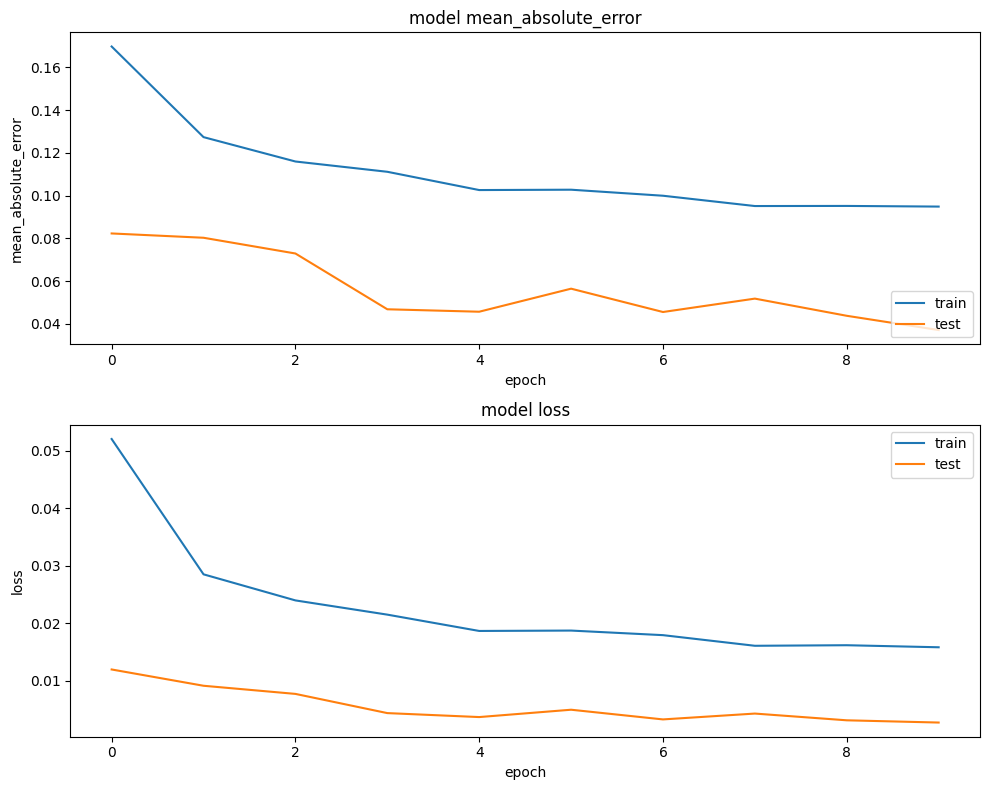

In [ ]:
# plotting the metrics
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Los valores de error son bastante bajos en proporcion alos valores de entrada. Comparemos como se ven la parte de la serie temporal del test real vs la predicha por la red.

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


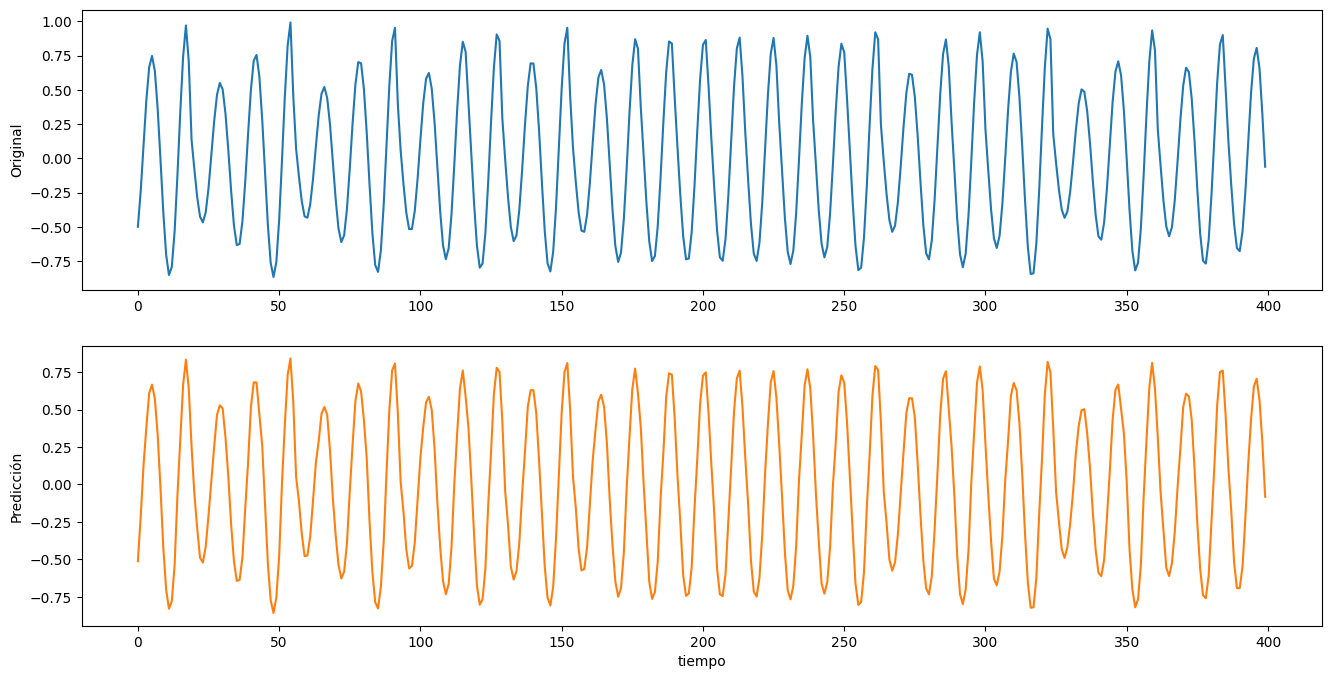

In [ ]:
pasos_adelante = 400
Y_test_pred = model.predict(X_test)

fig = plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
plt.plot(Y_test[0:pasos_adelante])
plt.ylabel('Original')
plt.subplot(2,1,2)
plt.plot(Y_test_pred[0:pasos_adelante],c='C1')
plt.ylabel('Predicción')
plt.xlabel('tiempo')
plt.show()

**Ejercicios:**


*   Detenerse en este punto y responder la siguiente pregunta: ¿Significa entonces que el modelo de alguna manera capturo la dinámica caótica del sistema?
*   ¿Como explica que ambas curvas sean tan similares?



### Predicción de multiples pasos adelante

La predicción con la cual entrenamos y evaluamos el modelo es para un único paso en el futuro. Es decir estamos siempre prediciendo el siguiente valor de la serie temporal, pero condicionado por los `look_back` pasos anteriores, los cuales se obtuvieron del atractor original.

Para evaluar una predicción del modelo a largo plazo y poder determinar si la red neuronal efectivamente esta capturando la dinamica de las ecuaciones diferenciales, deberíamos no solo predecir el siguiente paso, sino ver que pasa cuando miramos n pasos hacia adelante.

Para realizar esto, debemos predecir el siguiente paso y luego usar ese mismo paso como entrada de la proxima predicción y así sucesivamente.

In [ ]:
pasos_adelante = 400

# Tomamos el primer vector del X_test
vec_actual = X_test[0]

# Preparamos una lista vacia que vamos a ir llenando con los valores predichos
lista_valores = []

# Recorremos n pasos hacia adelante
for i in range(pasos_adelante):

    #predecimos el paso siguiente
    nuevo_valor = model.predict(vec_actual.reshape(1,vec_actual.shape[0]))

    # Lo agregamos a la lista
    lista_valores.append(nuevo_valor[0][0])

    # Actualizmaos el vector actual con este paso
    vec_actual = np.roll(vec_actual, -1)
    vec_actual[-1] = nuevo_valor[0][0]

lista_valores = np.asarray(lista_valores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

Ahora si, comparemos este serie temporal predicha por la red con la serie verdadera.

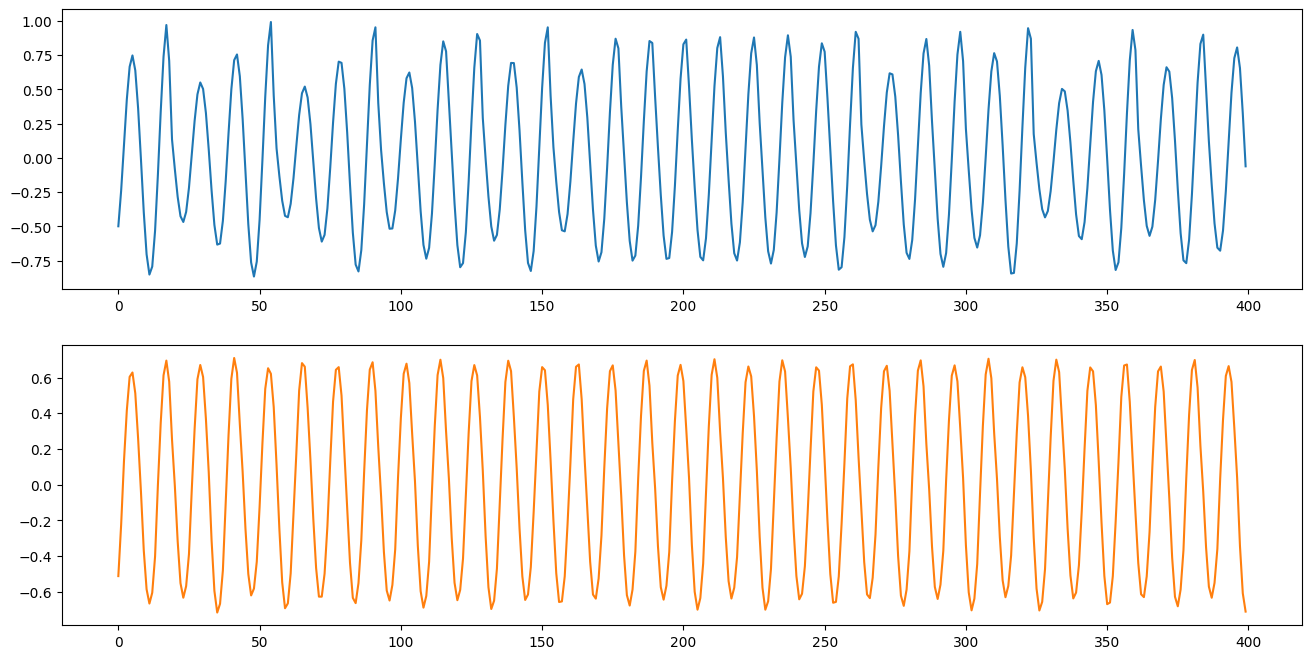

In [ ]:
fig = plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
plt.plot(Y_test[0:pasos_adelante])
plt.subplot(2,1,2)
plt.plot(lista_valores,c='C1')

**Ejercicios:**

*   ¿Que puede decir de la predicción? Mas allá de la parte cuantitativa, ¿es caulitativamente equivalente a la serie original?
*   Vuelva a reproducir los resultados pero esta vez utilizando la variable z del Rossler. Antes de ejecutarlo, piense si espera que le sea mas facil o mas dificil a la red esta tarea.
*   Repita el procedimiento, pero esta vez para un sistema de Lorenz.